# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [3]:
# Adjust figure size to be bigger:
plt.rcParams['figure.figsize'] = [15, 6]

In [4]:
#sns.set_theme()

# Check Recordings

In [5]:
import tvh_check_upcoming_recs as check

## Load DataFrame

In [6]:
df = check.get_df()
df

ATTRIBUTES,Title,Channel,Start,Stop,Duration
INDEX,,,,,
0,Entre deux draps,Noovo,2023-08-15 19:30:00,2023-08-15 20:00:00,0 days 00:30:00
1,SkyMed,CBC,2023-08-16 21:00:00,2023-08-16 22:00:00,0 days 01:00:00
2,...Moi non plus!,Noovo,2023-08-17 19:30:00,2023-08-17 20:00:00,0 days 00:30:00
3,En tout cas,TVA,2023-08-19 13:30:00,2023-08-19 14:00:00,0 days 00:30:00
4,Discussions avec mes parents,Radio-Canada,2023-08-21 19:30:00,2023-08-21 20:00:00,0 days 00:30:00
5,Contre-offre,Noovo,2023-08-21 19:30:00,2023-08-21 20:00:00,0 days 00:30:00
6,Entre deux draps,Noovo,2023-08-22 19:30:00,2023-08-22 20:00:00,0 days 00:30:00
7,SkyMed,CBC,2023-08-23 21:00:00,2023-08-23 22:00:00,0 days 01:00:00
8,...Moi non plus!,Noovo,2023-08-24 19:30:00,2023-08-24 20:00:00,0 days 00:30:00


## Test Data

### Smaller Data

In [7]:
"""
df = df.head(10)
df = df.iloc[1:4]
df = df.tail(2)
df.reset_index(drop=True, inplace=True)
df
"""

'\ndf = df.head(10)\ndf = df.iloc[1:4]\ndf = df.tail(2)\ndf.reset_index(drop=True, inplace=True)\ndf\n'

In [8]:
df.loc[0, 'Stop']

Timestamp('2023-08-15 20:00:00')

In [9]:
df.loc[0, 'Stop'] - df.loc[0, 'Start']

Timedelta('0 days 00:30:00')

In [10]:
type(_)

pandas._libs.tslibs.timedeltas.Timedelta

### Fudged Data

In [11]:
# """
df = pd.DataFrame({'Start': [ 0, 0, 1, 2, 3, 4, 5, 6, 6, 9],
                   'Stop' : [ 1, 4, 2, 3, 4, 8, 6, 7, 8, 10]})
df.sort_values(by=['Start', 'Stop'], ascending=[True, False], inplace=True, ignore_index=True)
df.rename_axis('ATTRIBUTES', axis='columns', inplace=True)
df.rename_axis('INDEX', axis='index', inplace=True)
df
# """

ATTRIBUTES,Start,Stop
INDEX,,
0,0,4
1,0,1
2,1,2
3,2,3
4,3,4
5,4,8
6,5,6
7,6,8
8,6,7


## Analysis

### Graph

In [12]:
def plot_rec(df):
    offset = df['Start'].min()
    x1 = df['Start'] #- offset
    x2 = df['Stop'] #- offset
    plt.barh(left=x1, width=x2-x1, y=df.index, height=.8)
    plt.grid()

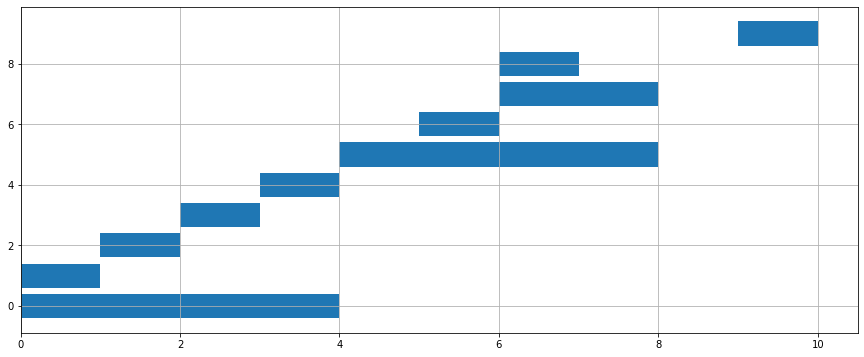

In [13]:
plot_rec(df)

### Processing

How to analyze:
* Loop on the df and store the start & stop time in a new df, in the same column with a column attribute indicating start or stop
* Sort this new df ascending according to the time column, put stop first when same time.
* Loop this df:
  * Increment a tuner count when on a start time
  * Decrement a tuner count when on a stop time

In [14]:
data = []
for index, row in df.iterrows():
    data.append([row['Start'], 1, index])
    data.append([row['Stop'], 0, index])

dfa = pd.DataFrame(data=data, columns=['Time', 'Type', 'RecIndex'])
dfa.sort_values(by=['Time', 'Type', 'RecIndex'], ascending=[True, True, True], inplace=True, ignore_index=True)
dfa.rename_axis('ATTRIBUTES', axis='columns', inplace=True)
dfa.rename_axis('INDEX', axis='index', inplace=True)

dfa

ATTRIBUTES,Time,Type,RecIndex
INDEX,,,
0,0,1,0
1,0,1,1
2,1,0,1
3,1,1,2
4,2,0,2
5,2,1,3
6,3,0,3
7,3,1,4
8,4,0,0


In [15]:
dfa.describe()

ATTRIBUTES,Time,Type,RecIndex
count,20.000000,20.000000,20.000000
mean,4.450000,0.500000,4.500000
std,2.999561,0.512989,2.946898
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000
50%,4.000000,0.500000,4.500000
75%,6.250000,1.000000,7.000000
max,10.000000,1.000000,9.000000


In [16]:
df['NbTunerRequired'] = 0
df.head()

ATTRIBUTES,Start,Stop,NbTunerRequired
INDEX,,,
0,0,4,0
1,0,1,0
2,1,2,0
3,2,3,0
4,3,4,0


In [17]:
recording_stack = []
for index, row in dfa.iterrows():
    if row['Type'] > 0: # Start
        recording_stack.append(row['RecIndex'])
        df.loc[recording_stack, 'NbTunerRequired'] = len(recording_stack)
        if len(recording_stack) > check.MAX_CONCURRENT_RECORDING:
            print('--------------------------------------------------')
            print(df.loc[recording_stack])
    else:
        _ = recording_stack.pop()

--------------------------------------------------
ATTRIBUTES  Start  Stop  NbTunerRequired
INDEX                                   
5               4     8                3
7               6     8                3
8               6     7                3


In [18]:
df[df['NbTunerRequired'] > check.MAX_CONCURRENT_RECORDING]

ATTRIBUTES,Start,Stop,NbTunerRequired
INDEX,,,
5,4,8,3
7,6,8,3
8,6,7,3


In [19]:
check.analyze_df(df)

--------------------------------------------------
ATTRIBUTES  Start  Stop  NbTunerRequired
INDEX                                   
5               4     8                3
7               6     8                3
8               6     7                3


ATTRIBUTES,Start,Stop,NbTunerRequired
INDEX,,,
5,4,8,3
7,6,8,3
8,6,7,3


## All-in-one

In [20]:
check.analyze_df(check.get_df())

ATTRIBUTES,Title,Channel,Start,Stop,Duration,NbTunerRequired
INDEX,,,,,,


# Re-enable autorecordings

In [21]:
import re

In [22]:
import tvh_reenable_autorecs as rea

In [23]:
dir(rea)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_main',
 'get_autorecs',
 'json',
 'set_autorec_enabled',
 'ta',
 'time',
 'urllib']

In [24]:
ar = rea.get_autorecs()

In [25]:
t = None
for r in ar['entries']:
    if re.search('drap', r['name']):
        t = r
        print(t)

{'uuid': '7e2b1b35e14a640ab7728e21f1da4c76', 'enabled': True, 'name': 'Entre deux draps', 'directory': 'Entre-deux-draps', 'title': 'Entre deux draps', 'fulltext': False, 'channel': '43bd2daafc3b4ee9a460ce48909673eb', 'tag': '', 'btype': 0, 'content_type': 0, 'start': 'Any', 'start_window': 'Any', 'start_extra': 0, 'stop_extra': 0, 'weekdays': [1, 2, 3, 4, 5, 6, 7], 'minduration': 0, 'maxduration': 0, 'pri': 2, 'record': 0, 'retention': 0, 'removal': 0, 'maxcount': 0, 'maxsched': 0, 'config_name': '8d0f5b7ae354d956d7fe5db25f5d0d24', 'brand': '', 'season': '', 'serieslink': '', 'creator': '192.168.1.51', 'comment': 'Entre deux draps'}


In [26]:
rea.set_autorec_enabled(t['uuid'], False)

{}

In [27]:
rea.set_autorec_enabled(t['uuid'], True)

{}